In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.signal as ssig
import lalsimulation as lalsim 
import numpy as np
import jax.numpy as jnp
import jax

import matplotlib.pyplot as plt
from diffwaveform.waveforms.IMRPhenomD import gen_IMRPhenomD

### First lets look at generating some noise with lalsim (from Max's notebook)

In [3]:
psd_func_dict = {
    'H1': lalsim.SimNoisePSDaLIGOZeroDetHighPower,
    'L1': lalsim.SimNoisePSDaLIGOZeroDetHighPower,
    'V1': lalsim.SimNoisePSDAdvVirgo,
}
ifos = list(psd_func_dict.keys())

In [4]:
print(psd_func_dict["H1"](50.0))

2.475897902328087e-47


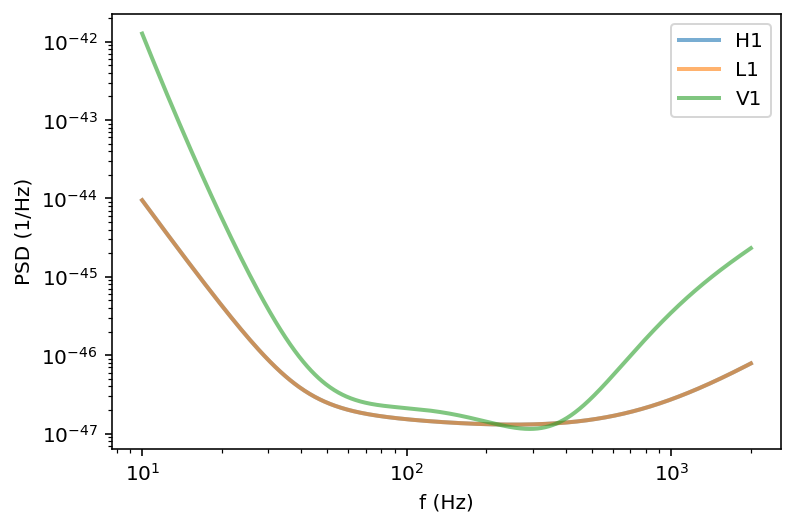

In [5]:
fs = np.linspace(10, 2e3, 4096)
for ifo, psd in psd_func_dict.items():
    plt.loglog(fs, np.vectorize(psd)(fs), label=ifo, alpha=0.6, lw=2)
plt.xlabel('f (Hz)')
plt.ylabel('PSD (1/Hz)')
plt.legend()
plt.show()

In [6]:
# define center of time array
tgps_geo = 1126259462.423

# define sampling rate and duration
fsamp = 8192
duration = 4

delta_t = 1/fsamp
tlen = int(round(duration / delta_t))

epoch = tgps_geo - 0.5*tlen*delta_t

time_dict = {i: np.arange(tlen)*delta_t + epoch for i in ifos}

In [7]:
f_l = 30
f_u = 1024
df = 0.001
f_list = np.arange(f_l, f_u, df)

freqs = np.fft.rfftfreq(tlen, delta_t)
delta_f = freqs[1] - freqs[0]

In [8]:
# we will want to pad low frequencies; the function below applies a
# prescription to do so smoothly, but this is not really needed: you
# could just set all values below `fmin` to a constant.
fmin = 10
def pad_low_freqs(f, psd_ref):
    return psd_ref + psd_ref*(fmin-f)*np.exp(-(fmin-f))/3

psd_dict = {}
for ifo in ifos:
    psd = np.zeros(len(freqs))
    for i,f in enumerate(freqs):
        if f >= fmin:
            psd[i] = psd_func_dict[ifo](f)
        else:
            psd[i] = pad_low_freqs(f, psd_func_dict[ifo](fmin))
    psd_dict[ifo] = psd

In [9]:
rng = np.random.default_rng(12345)

noise_fd_dict = {}
for ifo, psd in psd_dict.items():
    var = psd / (4.*delta_f)  # this is the variance of LIGO noise given the definition of the likelihood function
    noise_real = rng.normal(size=len(psd), loc=0, scale=np.sqrt(var))
    noise_imag = rng.normal(size=len(psd), loc=0, scale=np.sqrt(var))
    noise_fd_dict[ifo] = noise_real + 1j*noise_imag

/usr/local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


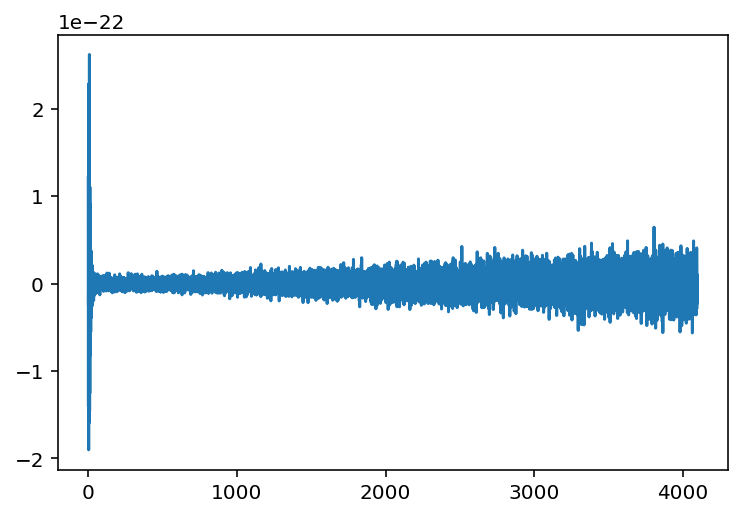

In [10]:
# So now lets look at the noise we have generated in H1. Looks good to me!
plt.plot(freqs, noise_fd_dict["H1"])

### Now lets generate a waveform and add them together

In [13]:
# Now lets compute the waveform ripple
m1 = 20.0
m2 = 10.0
from diffwaveform import ms_to_Mc_eta
Mc, eta = ms_to_Mc_eta(jnp.array([m1, m2]))
chi1 = 0.0
chi2 = 0.0
D = 100
tc = 0.01
phic = 0.0

f_list = freqs[freqs>fmin]
params = jnp.array([Mc, eta, chi1, chi2, D, tc, phic])
hp = gen_IMRPhenomD(f_list, params)

/usr/local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


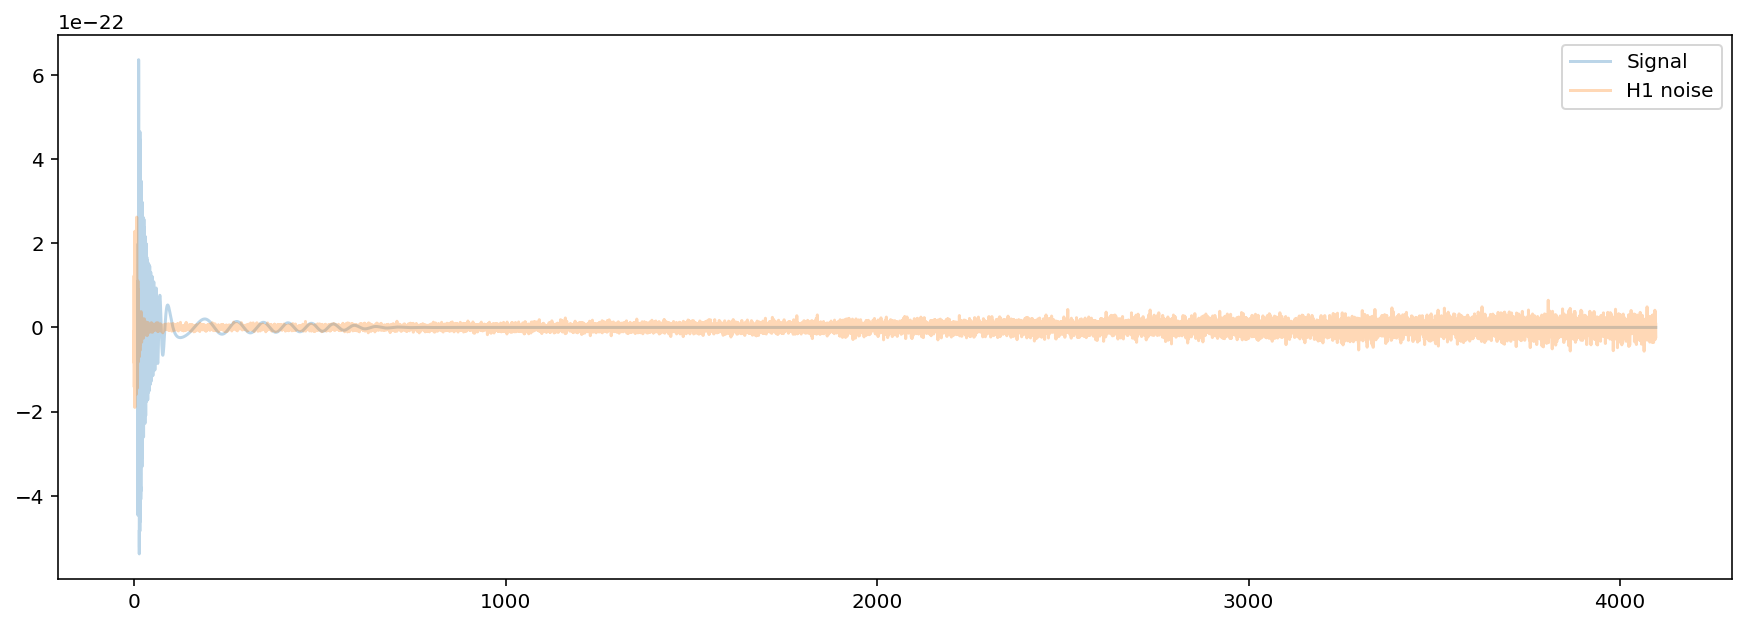

In [14]:
plt.figure(figsize=(15,5))
plt.plot(f_list, hp, label="Signal", alpha=0.3)
plt.plot(freqs, noise_fd_dict["H1"], label="H1 noise", alpha=0.3)
plt.legend()
plt.show()

In [17]:
# Note that I'm only using frequencies above 10 Hz since the waveform generation is not 
# reliable below this
data = noise_fd_dict["H1"][freqs>fmin] + hp

### Finally, lets set up a numpyro MCMC

In [15]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

prior_sigma_Mc = 5.0
prior_sigma_eta = 0.1
prior_sigma_chi = 5.0
prior_sigma_D = 10.0

prior_sigma_tc = 0.01
prior_sigma_phic = 0.01


def numpyro_likelihood(f, Y):
    # Parameters of the model
    Mc_pyro = numpyro.sample("Mc_pyro", dist.Normal(Mc, prior_sigma_Mc))
    eta_pyro = numpyro.sample("eta_pyro", dist.Normal(eta, prior_sigma_eta))
    
    chi1_pyro = numpyro.sample("chi1_pyro", dist.Normal(chi1, prior_sigma_chi))
    chi2_pyro = numpyro.sample("chi2_pyro", dist.Normal(chi2, prior_sigma_chi))
    
    D_pyro = numpyro.sample("D_pyro", dist.Normal(D, prior_sigma_D))
    
    tc_pyro = numpyro.sample("tc_pyro", dist.Uniform(tc-prior_sigma_tc, tc+prior_sigma_tc))
    phic_pyro = numpyro.sample("phic_pyro", dist.Normal(phic, prior_sigma_phic))
    
    # This is the part I'm not sure I understand...
    # I'm not sure which part should be data and which part is 
    params = jnp.array([Mc, eta, chi1, chi2, D, tc, phic])
    waveform = gen_IMRPhenomD(f, params)
    numpyro.sample("waveform", gen_IMRPhenomD.numpyro_dist(), obs=Y)

In [ ]:
nuts_kernel = NUTS(numpyro_likelihood, dense_mass=True, target_accept_prob=0.9)
mcmc = MCMC(
    nuts_kernel,
    num_warmup=1000,
    num_samples=1000,
    num_chains=2,
    progress_bar=False,
)
rng_key = jax.random.PRNGKey(34923)

%%time
# ???
mcmc.run(rng_key, f_list, y=data)
samples = mcmc.get_samples()
pred = samples["pred"].block_until_ready()  # Blocking to get timing right